In [1]:
from scipy.spatial.distance import cdist,pdist

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randint

In [2]:
import os
import sys
#SERVE PER POTER IMPORTARE I FILE .PY DALLA CARTELLA SOURCE
sys.path.append('..')
sys.path.append('..\data')
from sklearn.decomposition import PCA

#ora src è un pacchetto e posso usare la classica dot notation di python
from src.data_load_notebook  import *
#import pandas as pd
# ||||||||||è un utilizzo un pò improprio di import, basta ricordare che così importiamo pandas
from src import classes
from src import funzioni
from src import cluster_routine
import numpy as np

In [3]:
picchi1 = classes.Spettri(data1)
picchi2 = classes.Spettri(data2)
picchi1.peakfinder()
picchi2.peakfinder()
picchi1.featextract()
picchi2.featextract()
pass

#### *cluster_routine.py* 

Contiene routine per sondare velocemente con più traning per diversi parametri
e valutare sommartiamente quali sono preferibili.
Ovviamente non a sostituire un *Hyperparameter Tuning* con *GridSearchCV* e *Pipelines*, ma per orientarsi semmai in attesa di una definizione soddisfacente di uno *scoring*....
Infatti nelle routine di clustering considero sia il silhouette score che il davies_boulidn_score(più basso->meglio controintuitivamente, per uno score) che, per kMeans l'andamento dell'inertia (elbow method)

con 2 clusters, davies_bouldin_score : 0.51
con 2 clusters, silohuette_score : 0.63
con 3 clusters, davies_bouldin_score : 0.53
con 3 clusters, silohuette_score : 0.56
con 4 clusters, davies_bouldin_score : 0.49
con 4 clusters, silohuette_score : 0.61
con 5 clusters, davies_bouldin_score : 0.50
con 5 clusters, silohuette_score : 0.56
con 6 clusters, davies_bouldin_score : 0.51
con 6 clusters, silohuette_score : 0.56
con 7 clusters, davies_bouldin_score : 0.52
con 7 clusters, silohuette_score : 0.55
con 8 clusters, davies_bouldin_score : 0.52
con 8 clusters, silohuette_score : 0.54
con 9 clusters, davies_bouldin_score : 0.51
con 9 clusters, silohuette_score : 0.56
con 10 clusters, davies_bouldin_score : 0.45
con 10 clusters, silohuette_score : 0.55


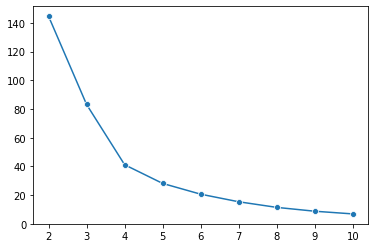

con 2 clusters, davies_bouldin_score : 0.40
con 2 clusters, silohuette_score : 0.91
con 3 clusters, davies_bouldin_score : 0.53
con 3 clusters, silohuette_score : 0.61
con 4 clusters, davies_bouldin_score : 0.32
con 4 clusters, silohuette_score : 0.61
con 5 clusters, davies_bouldin_score : 0.35
con 5 clusters, silohuette_score : 0.57
con 6 clusters, davies_bouldin_score : 0.39
con 6 clusters, silohuette_score : 0.58
con 7 clusters, davies_bouldin_score : 0.36
con 7 clusters, silohuette_score : 0.59
con 8 clusters, davies_bouldin_score : 0.37
con 8 clusters, silohuette_score : 0.59
con 9 clusters, davies_bouldin_score : 0.35
con 9 clusters, silohuette_score : 0.60
con 10 clusters, davies_bouldin_score : 0.37
con 10 clusters, silohuette_score : 0.57


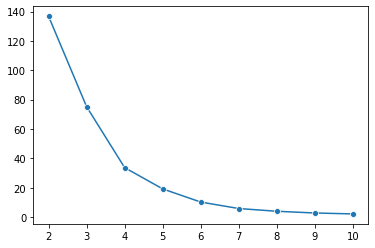

In [4]:
#il parametro plot: Bool controlla se plottare l'andamento del coefficente .inertia mostro un esempioper picchi1
km1_list= cluster_routine.km_cluster_plt(picchi1.feature, pca =1, plot = True)
km2_list =  cluster_routine.km_cluster_plt(picchi2.feature, pca = 1, plot = True)
#feat_picchi1['labels_km']=  km1_list[1].labels_
#feat_picchi2['labels_km']= km2_list[1].labels_


Incrociando un attimo gli score, si vede che sono tendenzialmente in accordo sul numero di cluster preferibile:
- **picchi1**, l'elbow method indica 4 o 5 come un buon numero, ma gli altri score sono migliori per **4**
- **picchi2**, l'elbow method indica sempre 4 o 5 clusters, ma ancora gli altri indicano **4** come ottimale

e si può dire anche che secondo questi score, il clustering sembra un pò più soddisfacente per il secondo campione, tuttavia a questo livello è ancora un analisi molto qualitativa...
Inoltre, nel clusteriing finale bisognerà ottimizzare anche per npicchi, le componenti dalla pca utilizzati 

Rimando un clustering definitivo in secondo luogo, prima introduco una valutazione un pò più realistica sul clustering...
L'assunzione è che possibilmente i diversi materiali saranno spazialmente raggruppati rispetto alla griglia di acquisizione, e vogliamo valutare se il clustering evidenzi questo aspetto.
Se l'assunzione fosse corretta potrei utilizzare questa valutazione in qualche modo come target, in quanto lo spazio in cui eseguo il clustering non è lo stesso fisico del campione. A differenza dei precedenti score dà più informazione rispetto al potere rappresentativo del clustering rispetto all'assunzione  perchè non è direttamente collegato al meccanismo del clustering in particolare. 

# Come valutare il clustering unsupervised?

## Target qualitativo

La funzione distplot **all'interno del modulo funzioni.py** è molto specializzata per prendere una serie di labels ordinate 
secondo la solita lista di identificativi e far **visualizzare** come si distribuiscono i cluster nella reale
griglia spaziale con unità di un micron.... qui sotto un esempio simile alla funzione

    l = [(x,y) for x in range(1,12) for y in range(1,12)]
    grid = np.array(l).astype(float)
    plt.xlim(0,14)
    plt.ylim(0,14)
    fig = plt.gcf()
    fig.set_size_inches(11, 7)
    sns.scatterplot(x = grid[:,0], y = grid[:,1], hue = feat_picchi1['labels_km'])

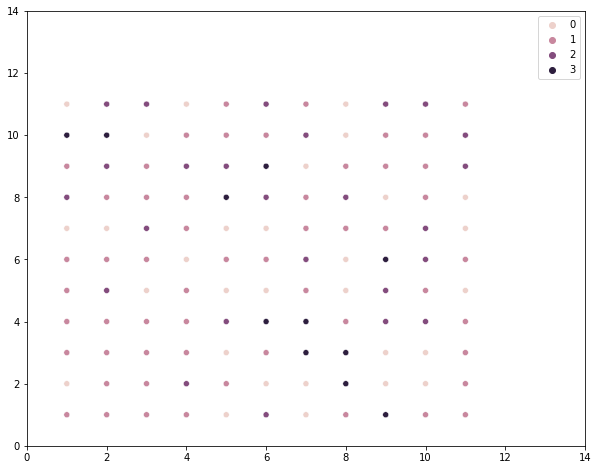

In [5]:
funzioni.distpoint(km1_list[2].labels_)

## Target quantitativo

Provo valutando la distanza media spaziale (sulla griglia) dei punti per i rispettivi cluster.
L'idea è che dovrebbe diminuire per i cluster se sono localizzati:
non è un amisura perfetta perchè:
- aumentando il numero di cluster e riducendo il numero di punti per cluster è probabile o possibile la media scenda anche senza aumentare la rappresentatività spaziale

#### scipy.spatial.distance.pdist()

Calcola la pairwise distance di un array multidimensionale di punti in pardicolare se la dimensione è NxD
si considera la distanza tra le possibili coppie (combinazioni) tra N punti D-dimensionali


In [6]:
'''
Qual'è la distanza media di tutti i punti del campione?
'''


l = [(x,y) for x in range(1,12) for y in range(1,12)]
grid = np.array(l).astype(float)
np.mean(pdist(grid))

5.758545271680614

La semplice funzione *index_translate* del modulo *funzioni.py* serve a tradurre una lista di indici (standard row-col) in un array di punti che possono già essere passati alla funzione pdist...
Tutto viene comunque eseguito automaticamente dalla funzione, sempre allo stesso modulo chiamata *spatial_score*

In [7]:
picchi1.feature['labels_km_4_clust'] =  km1_list[2].labels_ #uso il cluster kmean preferito
funzioni.index_translate(picchi1.feature[picchi1.feature['labels_km_4_clust']==0].index)[:4,:4] # ne stampo solo una parte

array([[1., 2.],
       [1., 7.],
       [1., 1.],
       [2., 7.]])

Anche se la funzione index_translate viene utilizzata solo all interno di spatial_score, senza la necessità di aggiungere la colonna di label al database di feature

In [8]:
#mostro l utilizzo di spatial_score, senza necisstà di un dataframe modificato con l'aggiunta della colonna di labels coem in picchi1
funzioni.spatial_score(picchi2.feature, labels_col= km2_list[5].labels_)

C:\Users\Utente\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Utente\miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'cluster_0_dist': 5.00656852175006,
 'cluster_1_dist': nan,
 'cluster_2_dist': 3.8016394490958887,
 'cluster_3_dist': 4.209527448546301,
 'cluster_4_dist': nan,
 'cluster_5_dist': 5.109627153820655,
 'cluster_6_dist': 5.276196044314912}

In [9]:
funzioni.spatial_score(picchi2.feature, km2_list[2].labels_)

C:\Users\Utente\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Utente\miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'cluster_0_dist': 5.1958807490558225,
 'cluster_1_dist': nan,
 'cluster_2_dist': 4.686465661080794,
 'cluster_3_dist': nan}

In [10]:
picchi1.feature.drop('labels_km_4_clust', axis = 1, inplace = True)